In [51]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [52]:
from b2heavy.FnalHISQMetadata import params as mData

In [53]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, ratio_correction_factor
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [54]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [55]:
ENSEMBLE = 'MediumCoarse'
RATIO    = 'QPLUS'
SMSLIST  = ['1S','RW']
# SMSLIST  = ['1S']
MOMLIST  = ['100','200','300','400']
# MOMLIST  = ['100','200','300']
# MOMLIST  = ['000']

In [56]:
if RATIO in ['RMINUS','RPLUS','QPLUS','XF']:
    meson = 'D'
else:
    meson = 'Dst'

In [57]:
TMIN    = 1
NSTATES = 1

In [58]:
requisites = ratio_prerequisites(
    ens      = ENSEMBLE,
    ratio    = RATIO,
    mom      = '200',
    readfrom = DATA_2PT,
    jk       = False
)

In [60]:
requisites

{'E0': 1.2408150500867592,
 'm0': 1.1850570505776856,
 'Z0': {'1S': 6.981485916478365, 'd': 0.1875886196484679},
 'Zpar': {'1S': None, 'd': None},
 'Zbot': {'1S': None, 'd': None},
 'Zp': {'1S': 5.349652947846599, 'd': 0.19087252928272566},
 'wrecoil': 1.0470508989266745,
 'jk': False}

In [61]:
io = RatioIO(ENSEMBLE,RATIO,'200',PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ENSEMBLE],
    smearing  = SMSLIST,
    readfrom  = DATA_2PT,
    **req
)

In [62]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 {'1S': array([0.7579(57), 0.7338(52), 0.7015(47), 0.6678(44), 0.6334(39),
         0.6011(36), 0.5721(32), 0.5433(29), 0.5157(27), 0.4902(26),
         0.4784(28)], dtype=object),
  'RW': array([0.9230(22), 0.8782(25), 0.8315(26), 0.7867(26), 0.7439(26),
         0.7045(25), 0.6684(23), 0.6336(22), 0.6009(20), 0.5707(20),
         0.5563(21)], dtype=object)})

In [63]:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 {'1S': array([0.7579(57), 0.7338(52), 0.7015(47), 0.6678(44), 0.6334(39),
         0.6011(36), 0.5721(32), 0.5433(29), 0.5157(27), 0.4902(26),
         0.4784(28)], dtype=object),
  'RW': array([0.9230(22), 0.8782(25), 0.8315(26), 0.7867(26), 0.7439(26),
         0.7045(25), 0.6684(23), 0.6336(22), 0.6009(20), 0.5707(20),
         0.5563(21)], dtype=object)})

<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:4: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:5: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:5: SyntaxWarning: 'float'

NameError: name 'array' is not defined

# ---------- chi^2_exp analysis -------------
# chi2_exp = 18.00000000000026 +/- 6.0000000000000435 
# p-value [eval] = 0.352
# p-value [MC]   = 0.35629999999999995
# ---------- 1+1 fit in (1, 9) for mes: QPLUS of ens: MediumCoarse for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 1 [18]    Q = 0.42    logGBF = 84.089

Parameters:
        ratio 0    0.9905 (19)      [  0.99 (10) ]  
         A_1S 0   -0.0086 (37)      [    0 ± 1.0 ]  
         B_1S 0    0.0030 (16)      [    0 ± 1.0 ]  
         A_RW 0    0.0038 (22)      [    0 ± 1.0 ]  
         B_RW 0    0.0034 (14)      [    0 ± 1.0 ]  
       dE_src 0     -1.27 (30)      [ -0.76 (50) ]  *
       dE_snk 0     -1.03 (46)      [ -1.08 (50) ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 15/0.0)
  fitter = scipy_least_squares    method = trf

# red chi2       = 17.56
# aug chi2       = 18.59
# chi2_exp       = 18.00
# chi2/chi_exp   = 1.03
# p-value (exp)  = 0.35
# p-value (std)  = 0.12
# -

Text(0.5, 1.0, 'MediumCoarse QPLUS')

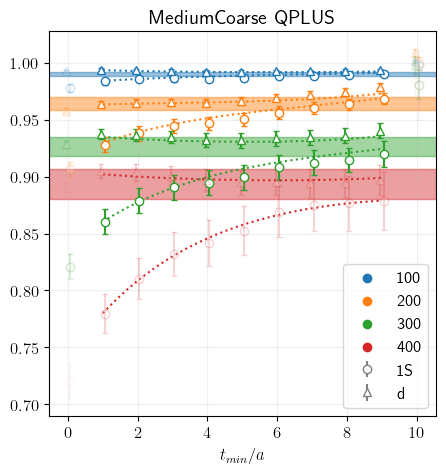

In [64]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,1,figsize=(5,5))

fits = []
f0s = []
for i,mom in enumerate(MOMLIST):
    requisites = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = False
    )

    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)
    robj = RatioFitter(
        io,
        jkBin     = BINSIZE[ENSEMBLE],
        smearing  = SMSLIST,
        readfrom  = DATA_2PT,
        **requisites
    )

    trange = (TMIN, robj.Ta-TMIN)

    cov_specs = dict(
        diag   = False,
        block  = False,
        scale  = True,
        shrink = True,
        cutsvd = 1E-12
    )

    dE_src = phys_energy_priors(ENSEMBLE,meson,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)

    fit = robj.fit(
        Nstates = NSTATES,
        trange  = trange,
        priors  = pr,
        verbose = False,
        **cov_specs
    )

    res = robj.fit_result(
        Nexc   = NSTATES,
        trange = trange,
        priors = pr 
    )

    fits.append({
        'ensemble': ENSEMBLE,
        'ratio'   : RATIO,
        'momentum': mom,
        'f0'      : fit.p['ratio'][0],
        'chiexp'  : res['chiexp'],
        'pstd'    : res['pstd']
    })


    alpha = 0.2 if mom=='400' else 1.
    robj.plot_fit(ax,NSTATES,trange,color=f'C{i}',color_res=f'C{i}',alpha=alpha)

    ax.scatter([],[], marker='o', color=f'C{i}', label=mom)


    f0s.append(fit.p['ratio'][0])

ax.errorbar([],[],[],fmt='o', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='1S')
ax.errorbar([],[],[],fmt='^', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='d')

# ax.set_xlim(-0.5,13)
# ax.set_ylim(ymax=0.08)
ax.grid(alpha=0.2)
ax.legend()

ax.set_xlabel(r'$t_{min}/a$')

ax.set_title(f'{ENSEMBLE} {RATIO}')


# plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_{RATIO}_multimom.pdf')

In [65]:
print(pd.DataFrame(fits).set_index(['ensemble','ratio','momentum']))

                                     f0  chiexp      pstd
ensemble     ratio momentum                              
MediumCoarse QPLUS 100       0.9905(19)    18.0  0.119354
                   200       0.9643(53)    18.0  0.188349
                   300       0.9266(84)    18.0  0.280449
                   400        0.893(13)    18.0  0.509228


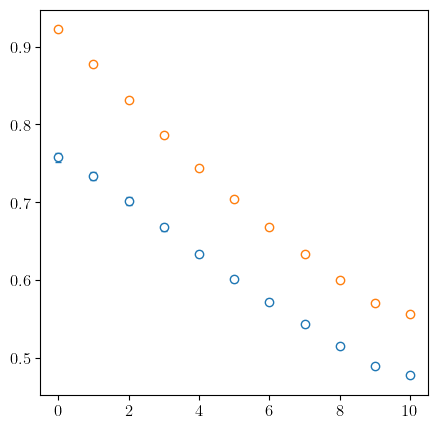

In [50]:
f, ax = plt.subplots(1,1,figsize=(5,5))

robj.plot(ax)